In [17]:
# Import Module
! pip install pandas
! pip install numpy
! pip install scipy
! pip install tqdm
! pip install seaborn
! pip install matplotlib
! pip install scikit-learn
! pip install xgboost
! pip install imblearn
! pip install pyarrow
! pip install fastparquet
import pandas as pd
import os
import numpy as np
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# Import Module
import pandas as pd
import os
import numpy as np
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.manifold import Isomap
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 66.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.7 MB/s eta 0:00:00


In [18]:
# Load data
train_df_path = 'input/child-mind-institute-problematic-internet-use/train.csv'
train_df = pd.read_csv(train_df_path)
test_df_path = 'input/child-mind-institute-problematic-internet-use/test.csv'
test_df = pd.read_csv(test_df_path)
train_parquet_path = "input/child-mind-institute-problematic-internet-use/series_train.parquet"
test_parquet_path = "input/child-mind-institute-problematic-internet-use/series_test.parquet"

In [19]:
# Preprocess Training Data
def Preprocess_Training_Data(train_df: pd.DataFrame) -> pd.DataFrame: 
    return_df = train_df.copy()

    age_masks = {
        '5-7': (return_df['Basic_Demos-Age'] >= 5) & (return_df['Basic_Demos-Age'] <= 7),
        '8-10': (return_df['Basic_Demos-Age'] >= 8) & (return_df['Basic_Demos-Age'] <= 10),
        '11-13': (return_df['Basic_Demos-Age'] >= 11) & (return_df['Basic_Demos-Age'] <= 13),
        '14-17': (return_df['Basic_Demos-Age'] >= 14) & (return_df['Basic_Demos-Age'] <= 17),
        '18-22': (return_df['Basic_Demos-Age'] >= 18) & (return_df['Basic_Demos-Age'] <= 22),
    }

    sex_masks = {
        '1': return_df['Basic_Demos-Sex'] == 1,
        '0': return_df['Basic_Demos-Sex'] == 0,
    }

    season_features = ['CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'SDS-Season']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for season_feature in season_features:
                if return_df.loc[age_mask & sex_mask, season_feature].value_counts().empty:
                    most_season = return_df[season_feature].value_counts().index[0]
                    return_df.loc[sex_mask & age_mask & return_df[season_feature].isna(), season_feature] = most_season
                else:
                    most_season = return_df.loc[age_mask & sex_mask, season_feature].value_counts().index[0]
                    return_df.loc[sex_mask & age_mask & return_df[season_feature].isna(), season_feature] = most_season
    
    # Physical Measures --------------------------------------------------------------------------------------------------- #
    return_df['Physical-Diastolic_BP'] = return_df.groupby('Physical-Season')['Physical-Diastolic_BP'].transform(lambda x: (x - x.mean()))
    return_df['Physical-Systolic_BP'] = return_df.groupby('Physical-Season')['Physical-Systolic_BP'].transform(lambda x: (x - x.mean()))
    return_df['Physical-HeartRate'] = return_df.groupby('Physical-Season')['Physical-HeartRate'].transform(lambda x: (x - x.mean()))
    physical_measures = ['Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for physical_measure in physical_measures:
                median = np.nan
                if return_df.loc[age_mask & sex_mask, physical_measure].notna().any():
                    median = return_df.loc[age_mask & sex_mask, physical_measure].median()
                elif return_df.loc[sex_mask, physical_measure].notna().any():
                    median = return_df.loc[sex_mask, physical_measure].median()
                else:
                    median = return_df[physical_measure].median()
                return_df.loc[sex_mask & age_mask & return_df[physical_measure].isna(), physical_measure] = median

    # Children's Global Assessment Scale ---------------------------------------------------------------------------------- #
    return_df.loc[(return_df['CGAS-CGAS_Score']>100)|(return_df['CGAS-CGAS_Score']<0), 'CGAS-CGAS_Score'] = pd.NA
    return_df['CGAS-CGAS_Score'] = return_df.groupby('CGAS-Season')['CGAS-CGAS_Score'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            median = np.nan
            if return_df.loc[age_mask & sex_mask, 'CGAS-CGAS_Score'].notna().any():
                median = return_df.loc[age_mask & sex_mask, 'CGAS-CGAS_Score'].median()
            elif return_df.loc[sex_mask, 'CGAS-CGAS_Score'].notna().any():
                median = return_df.loc[sex_mask, 'CGAS-CGAS_Score'].median()
            else:
                median = return_df['CGAS-CGAS_Score'].median()
            return_df.loc[sex_mask & age_mask & return_df['CGAS-CGAS_Score'].isna(), 'CGAS-CGAS_Score'] = median
    
    # FitnessGram Vitals and Treadmill ------------------------------------------------------------------------------------ #
    return_df['Fitness_Endurance-Max_Stage'] = return_df.groupby('Fitness_Endurance-Season')['Fitness_Endurance-Max_Stage'].transform(lambda x: (x - x.mean()))
    return_df['Fitness_Endurance-Time_Sec'] = return_df.groupby('Fitness_Endurance-Season')['Fitness_Endurance-Time_Sec'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            mean_max_stage = np.nan
            if return_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Max_Stage'].notna().any():
                mean_max_stage = return_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Max_Stage'].median()
            elif return_df.loc[sex_mask, 'Fitness_Endurance-Max_Stage'].notna().any():
                mean_max_stage = return_df.loc[sex_mask, 'Fitness_Endurance-Max_Stage'].median()
            else:
                mean_max_stage = return_df['Fitness_Endurance-Max_Stage'].median()
            return_df.loc[sex_mask & age_mask & return_df['Fitness_Endurance-Max_Stage'].isna(), 'Fitness_Endurance-Max_Stage'] = mean_max_stage
            mean_sec = np.nan
            if return_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Time_Sec'].notna().any():
                mean_sec = return_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Time_Sec'].median()
            elif return_df.loc[sex_mask, 'Fitness_Endurance-Time_Sec'].notna().any():
                mean_sec = return_df.loc[sex_mask, 'Fitness_Endurance-Time_Sec'].median()
            else:
                mean_sec = return_df['Fitness_Endurance-Time_Sec'].median()
            return_df.loc[sex_mask & age_mask & return_df['Fitness_Endurance-Time_Sec'].isna(), 'Fitness_Endurance-Time_Sec'] = mean_sec

    # FitnessGram Child --------------------------------------------------------------------------------------------------- #
    return_df['FGC-FGC_CU'] = return_df.groupby('FGC-Season')['FGC-FGC_CU'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_PU'] = return_df.groupby('FGC-Season')['FGC-FGC_PU'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_SRL'] = return_df.groupby('FGC-Season')[ 'FGC-FGC_SRL'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_SRR'] = return_df.groupby('FGC-Season')['FGC-FGC_SRR'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_TL'] = return_df.groupby('FGC-Season')['FGC-FGC_TL'].transform(lambda x: (x - x.mean()))
    two_categorical_fgc_features = ['FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items(): 
            for fgc_feature in two_categorical_fgc_features:
                zone = fgc_feature+'_Zone'
                mean = np.nan
                if return_df.loc[age_mask & sex_mask & (return_df[zone]==1), fgc_feature].notna().any():
                    mean = return_df.loc[age_mask & sex_mask & (return_df[zone]==1), fgc_feature].mean()
                else:
                    mean = return_df.loc[return_df[zone]==1, fgc_feature].mean()
                return_df.loc[sex_mask & age_mask & return_df[fgc_feature].isna(), fgc_feature] = mean
                return_df.loc[sex_mask & age_mask & return_df[zone].isna(), zone] = 1

    return_df['FGC-FGC_GSND'] = return_df.groupby('FGC-Season')['FGC-FGC_GSND'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_GSD'] = return_df.groupby('FGC-Season')['FGC-FGC_GSD'].transform(lambda x: (x - x.mean()))
    three_categorical_fgc_features = ['FGC-FGC_GSND', 'FGC-FGC_GSD']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for fgc_feature in three_categorical_fgc_features:
                zone = fgc_feature+'_Zone'
                mean = np.nan
                if return_df.loc[age_mask & sex_mask & (return_df[zone]==2), fgc_feature].notna().any():
                    mean = return_df.loc[age_mask & sex_mask & (return_df[zone]==2), fgc_feature].mean()
                else:
                    mean = return_df.loc[return_df[zone]==2, fgc_feature].mean()
                return_df.loc[sex_mask & age_mask & return_df[fgc_feature].isna(), fgc_feature] = mean
                return_df.loc[sex_mask & age_mask & return_df[zone].isna(), zone] = 2
    
    # Sleep Disturbance Scale --------------------------------------------------------------------------------------------- #
    return_df.loc[(return_df['SDS-SDS_Total_Raw']>100)|(return_df['SDS-SDS_Total_Raw']<0), 'SDS-SDS_Total_Raw'] = pd.NA
    return_df['SDS-SDS_Total_Raw'] = return_df.groupby('SDS-Season')['SDS-SDS_Total_Raw'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            mean_sds = np.nan
            if return_df.loc[age_mask & sex_mask, 'SDS-SDS_Total_Raw'].notna().any():
                mean_sds = return_df.loc[age_mask & sex_mask, 'SDS-SDS_Total_Raw'].mean()
            elif return_df.loc[sex_mask, 'SDS-SDS_Total_Raw'].notna().any():
                mean_sds = return_df.loc[sex_mask, 'SDS-SDS_Total_Raw'].mean()
            else:
                mean_sds = return_df['SDS-SDS_Total_Raw'].mean()
            return_df.loc[sex_mask & age_mask & return_df['SDS-SDS_Total_Raw'].isna(), 'SDS-SDS_Total_Raw'] = mean_sds
    
    # Bio-electric Impedance Analysis ------------------------------------------------------------------------------------- #
    return_df['BIA-BIA_BMC'] = return_df.groupby('BIA-Season')['BIA-BIA_BMC'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_BMI'] = return_df.groupby('BIA-Season')['BIA-BIA_BMI'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_BMR'] = return_df.groupby('BIA-Season')['BIA-BIA_BMR'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_DEE'] = return_df.groupby('BIA-Season')['BIA-BIA_DEE'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_ECW'] = return_df.groupby('BIA-Season')['BIA-BIA_ECW'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_FFM'] = return_df.groupby('BIA-Season')['BIA-BIA_FFM'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_FFMI'] = return_df.groupby('BIA-Season')['BIA-BIA_FFMI'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_FMI'] = return_df.groupby('BIA-Season')['BIA-BIA_FMI'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_Fat'] = return_df.groupby('BIA-Season')['BIA-BIA_Fat'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_ICW'] = return_df.groupby('BIA-Season')['BIA-BIA_ICW'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_LDM'] = return_df.groupby('BIA-Season')['BIA-BIA_LDM'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_LST'] = return_df.groupby('BIA-Season')['BIA-BIA_LST'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_SMM'] = return_df.groupby('BIA-Season')['BIA-BIA_SMM'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_TBW'] = return_df.groupby('BIA-Season')['BIA-BIA_TBW'].transform(lambda x: (x - x.mean()))
    numerical_bia_features = ['BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for bia_features in numerical_bia_features:
                mean = np.nan
                if return_df.loc[age_mask & sex_mask, bia_features].notna().any():
                    mean = return_df.loc[age_mask & sex_mask, bia_features].mean()
                elif return_df.loc[sex_mask, bia_features].notna().any():
                    mean = return_df.loc[sex_mask, bia_features].mean()
                else:
                    mean = return_df[bia_features].mean()
                return_df.loc[sex_mask & age_mask & return_df[bia_features].isna(), bia_features] = mean
    return_df.loc[return_df['BIA-BIA_Activity_Level_num'].isna(), 'BIA-BIA_Activity_Level_num'] = 3
    return_df.loc[return_df['BIA-BIA_Frame_num'].isna(), 'BIA-BIA_Frame_num'] = 2

    # Physical Activity Questionnaire ------------------------------------------------------------------------------------- #
    age_masks_PAQ = {
        '5-13': (return_df['Basic_Demos-Age'] >= 5) & (return_df['Basic_Demos-Age'] <= 13),
        '14-22': (return_df['Basic_Demos-Age'] >= 14) & (return_df['Basic_Demos-Age'] <= 22)
    }
    return_df['PAQ_Total'] = return_df['PAQ_A-PAQ_A_Total'].combine_first(return_df['PAQ_C-PAQ_C_Total'])
    return_df['PAQ_Season'] = return_df['PAQ_A-Season'].combine_first(return_df['PAQ_C-Season'])
    return_df['PAQ_Total'] = return_df.groupby('PAQ_Season')['PAQ_Total'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks_PAQ.items():
        for sex_label, sex_mask in sex_masks.items():
            mean_paq = return_df.loc[age_mask & sex_mask, 'PAQ_Total'].mean()
            return_df.loc[sex_mask & age_mask & return_df['PAQ_Total'].isna(), 'PAQ_Total'] = mean_paq
            most_paq_season = return_df.loc[age_mask & sex_mask, 'PAQ_Season'].value_counts().index[0]
            return_df.loc[sex_mask & age_mask & return_df['PAQ_Season'].isna(), 'PAQ_Season'] = most_paq_season
    
    return_df.drop(['Basic_Demos-Enroll_Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-SDS_Total_T', 'Fitness_Endurance-Time_Mins', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday'], axis=1, inplace=True)
    return_df.drop(['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
       'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20'], axis=1, inplace=True)
    return_df.drop(['CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'SDS-Season', 'PAQ_Season'], axis=1, inplace=True)
    
    return return_df

In [20]:
def Preprocess_Training_Parquet(train_parquet_path) -> pd.DataFrame:
    def Preprocess_Parquet(parquet: pd.DataFrame) -> pd.DataFrame:
        data = parquet.copy()
        data['timestamp'] = pd.to_datetime(data['relative_date_PCIAT'], unit='D') + pd.to_timedelta(data['time_of_day'])
        # remenber the non-wear-flag 
        non_wear_flag = data['non-wear_flag'].sum()
        total = len(data['non-wear_flag'])
        
        data = data[data['non-wear_flag'] == 0]
        hour = pd.to_datetime(data['time_of_day']).dt.hour
        time_masks = {
            'morning': (hour >= 6) & (hour < 12),
            'afternoon': (hour >= 12) & (hour < 17),
            'evening': (hour >= 17) & (hour < 22),
            'night': (hour >= 22) | (hour < 6)
        }
        
        features = dict()
        # season -----------------------------------------------------------------------------------------------#
        features.update({
            'actigraphy_season': data['quarter'].value_counts().index[0]
        })
        # weekend vs weekday -----------------------------------------------------------------------------------#
        proportions = data['weekday'].isin([6, 7]).value_counts(normalize=True).to_dict()
        features.update({
            'weekend/weekday': proportions.get(True, 0)
        })
        # time base data ---------------------------------------------------------------------------------------#
        for period, mask in time_masks.items():
            features.update({
                f'{period}_enmo_mean': data.loc[mask, 'enmo'].mean(),
                f'{period}_enmo_std': data.loc[mask, 'enmo'].std(),
                f'{period}_anglez_std': data.loc[mask, 'anglez'].std(),
            })
        # sleep quality ----------------------------------------------------------------------------------------#
        sleep_hours = time_masks['night']
        features.update({
            'sleep_disruption_count': len(data.loc[sleep_hours & (data['enmo'] > data['enmo'].mean() + 2 * data['enmo'].std())]),
            'light_exposure_during_sleep': data.loc[sleep_hours, 'light'].mean(),
            'light_exposure_during_sleep_std': data.loc[sleep_hours, 'light'].std(),
            'light_exposure_during_sleep_disruption': len(data.loc[sleep_hours & (data['light'] > data['light'].mean() + 2 * data['light'].std())]),
            'sleep_position_changes': len(data.loc[sleep_hours & (abs(data['anglez'].diff()) > 60)]),
            'good_sleep_cycle': int(data.loc[sleep_hours, 'light'].mean() < 50)
        })
        # non-wear metrices ------------------------------------------------------------------------------------#
        features.update({
            'wear_consistency': non_wear_flag / total,
        })
        # arm movement -----------------------------------------------------------------------------------------#
        bins = [-90, -60, -30, 0, 30, 60, 90]
        labels = ['anglez -90 to -60', 'anglez -60 to -30', 'anglez -30 to 0', 'anglez 0 to 30', 'anglez 30 to 60', 'anglez 60 to 90']
        interval_proportion_dict = pd.cut(data['anglez'], bins=bins, labels=labels, right=False).value_counts(normalize=True).sort_index().to_dict()
        features.update(interval_proportion_dict)

        return pd.DataFrame([features])
    
    ids = os.listdir(train_parquet_path)
    data_frames = []
    for file_id in tqdm(ids, desc="Preprocess Training Parquet"):
        result = Preprocess_Parquet(pd.read_parquet(os.path.join(train_parquet_path, file_id, 'part-0.parquet')))
        result['id'] = file_id.split('=')[1]
        data_frames.append(result)

    return pd.concat(data_frames, ignore_index=True)

In [21]:
# Merging data and qarquet
def Merging_Data_Parquet(data, parquet) -> pd.DataFrame:
    merged_train_df = pd.merge(data, parquet, on='id', how='left')
    merged_train_df['with_parquet'] = merged_train_df['actigraphy_season'].notna()
    sex_masks = {
        '1': merged_train_df['Basic_Demos-Sex'] == 1,
        '0': merged_train_df['Basic_Demos-Sex'] == 0,
    }

    # --------------------------------------------------------------------------------------------------- #
    time_zone_datas = ['morning_enmo_mean', 'morning_enmo_std', 'morning_anglez_std', 'afternoon_enmo_mean', 'afternoon_enmo_std', 'afternoon_anglez_std',
                       'evening_enmo_mean', 'evening_enmo_std', 'evening_anglez_std', 'night_enmo_mean', 'night_enmo_std', 'night_anglez_std']
    for sex_label, sex_mask in sex_masks.items():
        for time_zone_data in time_zone_datas:
            mean = np.nan
            if merged_train_df.loc[sex_mask, time_zone_data].notna().any():
                mean = merged_train_df.loc[sex_mask, time_zone_data].mean()
            else:
                mean = merged_train_df[time_zone_data].mean()
            merged_train_df.loc[sex_mask & merged_train_df[time_zone_data].isna(), time_zone_data] = mean

    # --------------------------------------------------------------------------------------------------- #
    sleep_datas = ['sleep_disruption_count', 'light_exposure_during_sleep', 'light_exposure_during_sleep_std', 
                   'light_exposure_during_sleep_disruption', 'sleep_position_changes', 'good_sleep_cycle']
    for sex_label, sex_mask in sex_masks.items():
        for sleep_data in sleep_datas:
            median = np.nan
            if merged_train_df.loc[sex_mask, sleep_data].notna().any():
                median = merged_train_df.loc[sex_mask, sleep_data].median()
            else:
                median = merged_train_df[sleep_data].median()
            merged_train_df.loc[sex_mask & merged_train_df[sleep_data].isna(), sleep_data] = median

    # --------------------------------------------------------------------------------------------------- #
    angles_datas = ['anglez -90 to -60', 'anglez -60 to -30', 'anglez -30 to 0', 'anglez 0 to 30', 'anglez 30 to 60', 'anglez 60 to 90']
    for sex_label, sex_mask in sex_masks.items():
        for angles_data in angles_datas:
            mean = np.nan
            if merged_train_df.loc[sex_mask, angles_data].notna().any():
                mean = merged_train_df.loc[sex_mask, angles_data].mean()
            else:
                mean = merged_train_df[angles_data].mean()
            merged_train_df.loc[sex_mask & merged_train_df[angles_data].isna(), angles_data] = mean

    season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
    merged_train_df['PCIAT-Season'] = merged_train_df['PCIAT-Season'].map(season_mapping)
    
    columns_to_exclude = ['PCIAT-Season', 'PCIAT-PCIAT_Total', 'sii']
    merged_train_df.fillna({col: 0 for col in merged_train_df.columns if col not in columns_to_exclude}, inplace=True)
    
    return merged_train_df

In [22]:
# Preprocessing
post_train_data = Preprocess_Training_Data(train_df)
post_train_parquet = Preprocess_Training_Parquet(train_parquet_path)
merged_train_df = Merging_Data_Parquet(post_train_data, post_train_parquet)

Preprocess Training Parquet: 100%|██████████| 996/996 [01:07<00:00, 14.68it/s]
/tmp/ipykernel_43373/3856072807.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(data_frames, ignore_index=True)


In [23]:
check_nan = merged_train_df[merged_train_df['with_parquet']==True].isna().sum()
check_nan.sum()

np.int64(0)

In [24]:
post_train_data['sii'].isna().sum()

np.int64(1224)

In [25]:
merged_train_df['sii'].isna().sum()

np.int64(1224)

In [26]:
merged_train_df['PCIAT-Season'].isna().sum()

np.int64(1224)

In [27]:
merged_train_df['PCIAT-PCIAT_Total'].isna().sum()

np.int64(1224)

In [28]:
# Preprocess Test Data
def Preprocess_Test_Data(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    total_df = pd.concat([train_df, test_df], ignore_index=True) # contain both 
    total_df.drop_duplicates(subset=['id'])
    
    return_df = test_df.copy()

    age_masks = {
        '5-7': (total_df['Basic_Demos-Age'] >= 5) & (total_df['Basic_Demos-Age'] <= 7),
        '8-10': (total_df['Basic_Demos-Age'] >= 8) & (total_df['Basic_Demos-Age'] <= 10),
        '11-13': (total_df['Basic_Demos-Age'] >= 11) & (total_df['Basic_Demos-Age'] <= 13),
        '14-17': (total_df['Basic_Demos-Age'] >= 14) & (total_df['Basic_Demos-Age'] <= 17),
        '18-22': (total_df['Basic_Demos-Age'] >= 18) & (total_df['Basic_Demos-Age'] <= 22),
    }

    sex_masks = {
        '1': total_df['Basic_Demos-Sex'] == 1,
        '0': total_df['Basic_Demos-Sex'] == 0,
    }

    season_features = ['CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'SDS-Season']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for season_feature in season_features:
                if total_df.loc[age_mask & sex_mask, season_feature].value_counts().empty:
                    most_season = total_df[season_feature].value_counts().index[0]
                    return_df.loc[sex_mask & age_mask & return_df[season_feature].isna(), season_feature] = most_season
                else:
                    most_season = total_df.loc[age_mask & sex_mask, season_feature].value_counts().index[0]
                    return_df.loc[sex_mask & age_mask & return_df[season_feature].isna(), season_feature] = most_season
    
    # Physical Measures --------------------------------------------------------------------------------------------------- #
    physical_measures = ['Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate']
    return_df['Physical-Diastolic_BP'] = total_df.groupby('Physical-Season')['Physical-Diastolic_BP'].transform(lambda x: (x - x.mean()))
    return_df['Physical-Systolic_BP'] = total_df.groupby('Physical-Season')['Physical-Systolic_BP'].transform(lambda x: (x - x.mean()))
    return_df['Physical-HeartRate'] = total_df.groupby('Physical-Season')['Physical-HeartRate'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for physical_measure in physical_measures:
                median = np.nan
                if total_df.loc[age_mask & sex_mask, physical_measure].notna().any():
                    median = total_df.loc[age_mask & sex_mask, physical_measure].median()
                elif total_df.loc[sex_mask, physical_measure].notna().any():
                    median = total_df.loc[sex_mask, physical_measure].median()
                else:
                    median = total_df[physical_measure].median()
                return_df.loc[sex_mask & age_mask & return_df[physical_measure].isna(), physical_measure] = median

    # Children's Global Assessment Scale ---------------------------------------------------------------------------------- #
    return_df.loc[(return_df['CGAS-CGAS_Score']>100)|(return_df['CGAS-CGAS_Score']<0), 'CGAS-CGAS_Score'] = pd.NA
    return_df['CGAS-CGAS_Score'] = total_df.groupby('CGAS-Season')['CGAS-CGAS_Score'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            median = np.nan
            if total_df.loc[age_mask & sex_mask, 'CGAS-CGAS_Score'].notna().any():
                median = total_df.loc[age_mask & sex_mask, 'CGAS-CGAS_Score'].median()
            elif total_df.loc[sex_mask, 'CGAS-CGAS_Score'].notna().any():
                median = total_df.loc[sex_mask, 'CGAS-CGAS_Score'].median()
            else:
                median = total_df['CGAS-CGAS_Score'].median()
            return_df.loc[sex_mask & age_mask & return_df['CGAS-CGAS_Score'].isna(), 'CGAS-CGAS_Score'] = median
    
    # FitnessGram Vitals and Treadmill ------------------------------------------------------------------------------------ #
    return_df['Fitness_Endurance-Max_Stage'] = total_df.groupby('Fitness_Endurance-Season')['Fitness_Endurance-Max_Stage'].transform(lambda x: (x - x.mean()))
    return_df['Fitness_Endurance-Time_Sec'] = total_df.groupby('Fitness_Endurance-Season')['Fitness_Endurance-Time_Sec'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            mean_max_stage = np.nan
            if total_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Max_Stage'].notna().any():
                mean_max_stage = total_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Max_Stage'].median()
            elif total_df.loc[sex_mask, 'Fitness_Endurance-Max_Stage'].notna().any():
                mean_max_stage = total_df.loc[sex_mask, 'Fitness_Endurance-Max_Stage'].median()
            else:
                mean_max_stage = total_df['Fitness_Endurance-Max_Stage'].median()
            return_df.loc[sex_mask & age_mask & return_df['Fitness_Endurance-Max_Stage'].isna(), 'Fitness_Endurance-Max_Stage'] = mean_max_stage
            mean_sec = np.nan
            if total_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Time_Sec'].notna().any():
                mean_sec = total_df.loc[age_mask & sex_mask, 'Fitness_Endurance-Time_Sec'].median()
            elif total_df.loc[sex_mask, 'Fitness_Endurance-Time_Sec'].notna().any():
                mean_sec = total_df.loc[sex_mask, 'Fitness_Endurance-Time_Sec'].median()
            else:
                mean_sec = total_df['Fitness_Endurance-Time_Sec'].median()
            return_df.loc[sex_mask & age_mask & return_df['Fitness_Endurance-Time_Sec'].isna(), 'Fitness_Endurance-Time_Sec'] = mean_sec

    # FitnessGram Child --------------------------------------------------------------------------------------------------- #
    return_df['FGC-FGC_CU'] = total_df.groupby('FGC-Season')['FGC-FGC_CU'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_PU'] = total_df.groupby('FGC-Season')['FGC-FGC_PU'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_SRL'] = total_df.groupby('FGC-Season')[ 'FGC-FGC_SRL'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_SRR'] = total_df.groupby('FGC-Season')['FGC-FGC_SRR'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_TL'] = total_df.groupby('FGC-Season')['FGC-FGC_TL'].transform(lambda x: (x - x.mean()))
    two_categorical_fgc_features = ['FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items(): 
            for fgc_feature in two_categorical_fgc_features:
                zone = fgc_feature+'_Zone'
                mean = np.nan
                if total_df.loc[age_mask & sex_mask & (total_df[zone]==1), fgc_feature].notna().any():
                    mean = total_df.loc[age_mask & sex_mask & (total_df[zone]==1), fgc_feature].mean()
                else:
                    mean = total_df.loc[total_df[zone]==1, fgc_feature].mean()
                return_df.loc[sex_mask & age_mask & return_df[fgc_feature].isna(), fgc_feature] = mean
                return_df.loc[sex_mask & age_mask & return_df[zone].isna(), zone] = 1

    return_df['FGC-FGC_GSND'] = total_df.groupby('FGC-Season')['FGC-FGC_GSND'].transform(lambda x: (x - x.mean()))
    return_df['FGC-FGC_GSD'] = total_df.groupby('FGC-Season')['FGC-FGC_GSD'].transform(lambda x: (x - x.mean()))
    three_categorical_fgc_features = ['FGC-FGC_GSND', 'FGC-FGC_GSD']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for fgc_feature in three_categorical_fgc_features:
                zone = fgc_feature+'_Zone'
                mean = np.nan
                if total_df.loc[age_mask & sex_mask & (total_df[zone]==2), fgc_feature].notna().any():
                    mean = total_df.loc[age_mask & sex_mask & (total_df[zone]==2), fgc_feature].mean()
                else:
                    mean = total_df.loc[total_df[zone]==2, fgc_feature].mean()
                return_df.loc[sex_mask & age_mask & return_df[fgc_feature].isna(), fgc_feature] = mean
                return_df.loc[sex_mask & age_mask & return_df[zone].isna(), zone] = 2
    
    # Sleep Disturbance Scale --------------------------------------------------------------------------------------------- #
    return_df.loc[(return_df['SDS-SDS_Total_Raw']>100)|(return_df['SDS-SDS_Total_Raw']<0), 'SDS-SDS_Total_Raw'] = pd.NA
    return_df['SDS-SDS_Total_Raw'] = total_df.groupby('SDS-Season')['SDS-SDS_Total_Raw'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            mean_sds = np.nan
            if total_df.loc[age_mask & sex_mask, 'SDS-SDS_Total_Raw'].notna().any():
                mean_sds = total_df.loc[age_mask & sex_mask, 'SDS-SDS_Total_Raw'].mean()
            elif total_df.loc[sex_mask, 'SDS-SDS_Total_Raw'].notna().any():
                mean_sds = total_df.loc[sex_mask, 'SDS-SDS_Total_Raw'].mean()
            else:
                mean_sds = total_df['SDS-SDS_Total_Raw'].mean()
            return_df.loc[sex_mask & age_mask & return_df['SDS-SDS_Total_Raw'].isna(), 'SDS-SDS_Total_Raw'] = mean_sds
    
    # Bio-electric Impedance Analysis ------------------------------------------------------------------------------------- #
    return_df['BIA-BIA_BMC'] = total_df.groupby('BIA-Season')['BIA-BIA_BMC'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_BMI'] = total_df.groupby('BIA-Season')['BIA-BIA_BMI'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_BMR'] = total_df.groupby('BIA-Season')['BIA-BIA_BMR'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_DEE'] = total_df.groupby('BIA-Season')['BIA-BIA_DEE'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_ECW'] = total_df.groupby('BIA-Season')['BIA-BIA_ECW'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_FFM'] = total_df.groupby('BIA-Season')['BIA-BIA_FFM'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_FFMI'] = total_df.groupby('BIA-Season')['BIA-BIA_FFMI'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_FMI'] = total_df.groupby('BIA-Season')['BIA-BIA_FMI'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_Fat'] = total_df.groupby('BIA-Season')['BIA-BIA_Fat'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_ICW'] = total_df.groupby('BIA-Season')['BIA-BIA_ICW'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_LDM'] = total_df.groupby('BIA-Season')['BIA-BIA_LDM'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_LST'] = total_df.groupby('BIA-Season')['BIA-BIA_LST'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_SMM'] = total_df.groupby('BIA-Season')['BIA-BIA_SMM'].transform(lambda x: (x - x.mean()))
    return_df['BIA-BIA_TBW'] = total_df.groupby('BIA-Season')['BIA-BIA_TBW'].transform(lambda x: (x - x.mean()))
    numerical_bia_features = ['BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    for range_label, age_mask in age_masks.items():
        for sex_label, sex_mask in sex_masks.items():
            for bia_features in numerical_bia_features:
                mean = np.nan
                if total_df.loc[age_mask & sex_mask, bia_features].notna().any():
                    mean = total_df.loc[age_mask & sex_mask, bia_features].mean()
                elif total_df.loc[sex_mask, bia_features].notna().any():
                    mean = total_df.loc[sex_mask, bia_features].mean()
                else:
                    mean = total_df[bia_features].mean()
                return_df.loc[sex_mask & age_mask & return_df[bia_features].isna(), bia_features] = mean
    return_df.loc[return_df['BIA-BIA_Activity_Level_num'].isna(), 'BIA-BIA_Activity_Level_num'] = 3
    return_df.loc[return_df['BIA-BIA_Frame_num'].isna(), 'BIA-BIA_Frame_num'] = 2

    # Physical Activity Questionnaire ------------------------------------------------------------------------------------- #
    age_masks_PAQ = {
        '5-13': (total_df['Basic_Demos-Age'] >= 5) & (total_df['Basic_Demos-Age'] <= 13),
        '14-22': (total_df['Basic_Demos-Age'] >= 14) & (total_df['Basic_Demos-Age'] <= 22)
    }

    total_df['PAQ_Total'] = total_df['PAQ_A-PAQ_A_Total'].combine_first(total_df['PAQ_C-PAQ_C_Total'])
    total_df['PAQ_Season'] = total_df['PAQ_A-Season'].combine_first(total_df['PAQ_C-Season'])
    return_df['PAQ_Total'] = return_df['PAQ_A-PAQ_A_Total'].combine_first(return_df['PAQ_C-PAQ_C_Total'])
    return_df['PAQ_Season'] = return_df['PAQ_A-Season'].combine_first(return_df['PAQ_C-Season'])
    return_df['PAQ_Total'] = total_df.groupby('PAQ_Season')['PAQ_Total'].transform(lambda x: (x - x.mean()))
    for range_label, age_mask in age_masks_PAQ.items():
        for sex_label, sex_mask in sex_masks.items():
            mean_paq = total_df.loc[age_mask & sex_mask, 'PAQ_Total'].mean()
            return_df.loc[sex_mask & age_mask & return_df['PAQ_Total'].isna(), 'PAQ_Total'] = mean_paq
            most_paq_season = total_df.loc[age_mask & sex_mask, 'PAQ_Season'].value_counts().index[0]
            return_df.loc[sex_mask & age_mask & return_df['PAQ_Season'].isna(), 'PAQ_Season'] = most_paq_season
    
    return_df.drop(['Basic_Demos-Enroll_Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-SDS_Total_T', 'Fitness_Endurance-Time_Mins', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday'], axis=1, inplace=True)
    return_df.drop(['CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'SDS-Season', 'PAQ_Season'], axis=1, inplace=True)

    return return_df

In [29]:
post_test_data = Preprocess_Test_Data(train_df, test_df)

In [30]:
# Preprocess Test Parquet
## Test data's parquet is same as train data.
post_test_parquet = Preprocess_Training_Parquet(test_parquet_path)

Preprocess Training Parquet: 100%|██████████| 2/2 [00:00<00:00, 30.16it/s]


In [31]:
# Merging test data and test qarquet
def Merging_Test_Data_Parquet(train_data, train_parquet, test_data, test_parquet) -> pd.DataFrame:
    merged_train_df = pd.merge(train_data, train_parquet, on='id', how='left')
    merged_test_df = pd.merge(test_data, test_parquet, on='id', how='left')
    merged_train_df['with_parquet'] = merged_train_df['actigraphy_season'].notna()
    merged_test_df['with_parquet'] = merged_test_df['actigraphy_season'].notna()
    total_merged_df = pd.concat([merged_train_df, merged_test_df], ignore_index=True)
    total_merged_df.drop_duplicates(subset=['id'])
    
    sex_masks = {
        '1': total_merged_df['Basic_Demos-Sex'] == 1,
        '0': total_merged_df['Basic_Demos-Sex'] == 0,
    }

    # --------------------------------------------------------------------------------------------------- #
    time_zone_datas = ['morning_enmo_mean', 'morning_enmo_std', 'morning_anglez_std', 'afternoon_enmo_mean', 'afternoon_enmo_std', 'afternoon_anglez_std',
                       'evening_enmo_mean', 'evening_enmo_std', 'evening_anglez_std', 'night_enmo_mean', 'night_enmo_std', 'night_anglez_std']
    for sex_label, sex_mask in sex_masks.items():
        for time_zone_data in time_zone_datas:
            mean = np.nan
            if total_merged_df.loc[sex_mask, time_zone_data].notna().any():
                mean = total_merged_df.loc[sex_mask, time_zone_data].mean()
            else:
                mean = total_merged_df[time_zone_data].mean()
            merged_test_df.loc[sex_mask & merged_test_df[time_zone_data].isna(), time_zone_data] = mean

    # --------------------------------------------------------------------------------------------------- #
    sleep_datas = ['sleep_disruption_count', 'light_exposure_during_sleep', 'light_exposure_during_sleep_std', 
                   'light_exposure_during_sleep_disruption', 'sleep_position_changes', 'good_sleep_cycle']
    for sex_label, sex_mask in sex_masks.items():
        for sleep_data in sleep_datas:
            median = np.nan
            if total_merged_df.loc[sex_mask, sleep_data].notna().any():
                median = total_merged_df.loc[sex_mask, sleep_data].median()
            else:
                median = total_merged_df[sleep_data].median()
            merged_test_df.loc[sex_mask & merged_test_df[sleep_data].isna(), sleep_data] = median

    # --------------------------------------------------------------------------------------------------- #
    angles_datas = ['anglez -90 to -60', 'anglez -60 to -30', 'anglez -30 to 0', 'anglez 0 to 30', 'anglez 30 to 60', 'anglez 60 to 90']
    for sex_label, sex_mask in sex_masks.items():
        for angles_data in angles_datas:
            mean = np.nan
            if total_merged_df.loc[sex_mask, angles_data].notna().any():
                mean = total_merged_df.loc[sex_mask, angles_data].mean()
            else:
                mean = total_merged_df[angles_data].mean()
            merged_test_df.loc[sex_mask & merged_test_df[angles_data].isna(), angles_data] = mean

    merged_test_df = merged_test_df.fillna(0)

    return merged_test_df

In [32]:
merged_test_df = Merging_Test_Data_Parquet(post_train_data, post_train_parquet, post_test_data, post_test_parquet)

In [33]:
check_nan = merged_test_df[merged_test_df['with_parquet']==True].isna().sum()
check_nan.sum()

np.int64(0)

In [34]:
# Result
merged_train_df
merged_train_df.to_pickle("working/merged_train_df_v3.pkl")

In [35]:
merged_test_df
merged_test_df.to_pickle("working/merged_test_df_v3.pkl")

In [36]:
# Check correlation
train_df = pd.read_pickle("working/merged_train_df_v3.pkl")
test_df = pd.read_pickle("working/merged_test_df_v3.pkl")

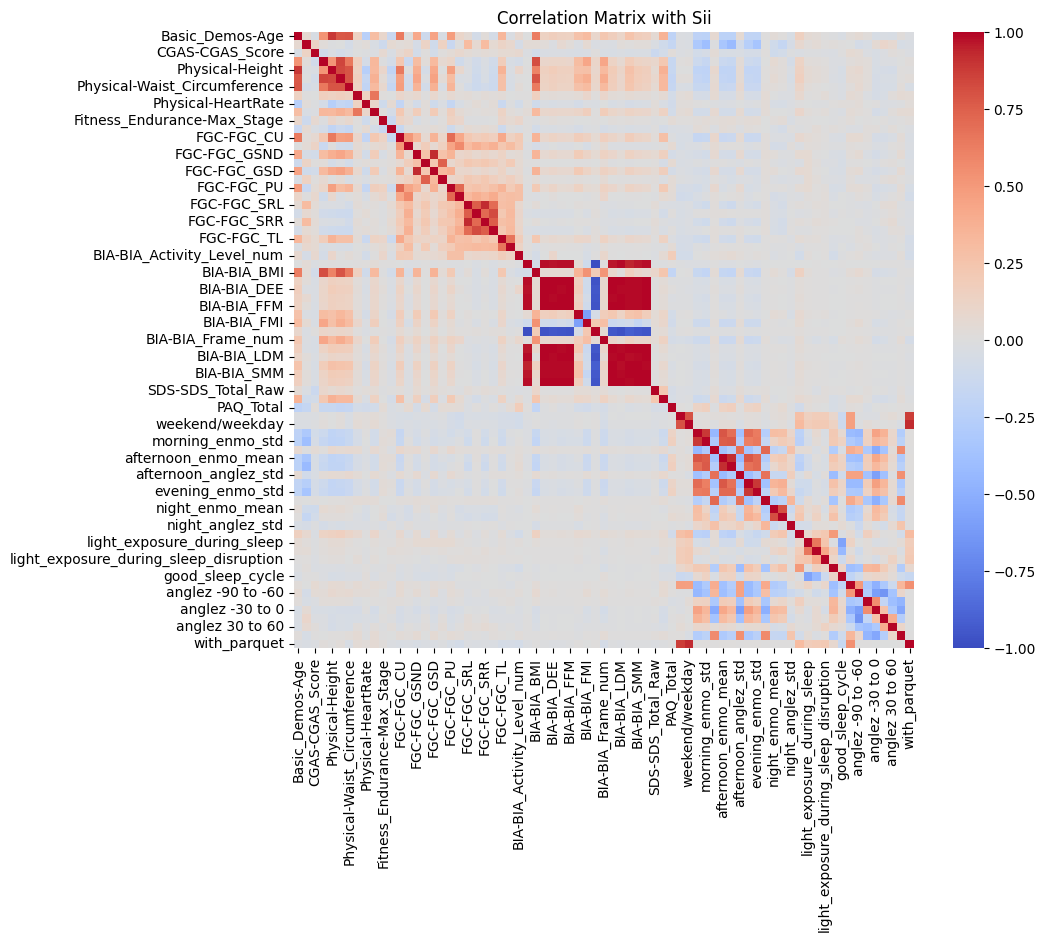

In [37]:
from scipy.spatial.distance import pdist, squareform
check_corr = train_df.drop(columns=['PCIAT-Season', 'PCIAT-PCIAT_Total', 'id'])
correlation_matrix = check_corr.corr()

sii_correlation = correlation_matrix['sii'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Sii')
plt.show()

In [38]:
print(sii_correlation.to_string())

sii                                       1.000000
Physical-Height                           0.374721
Basic_Demos-Age                           0.365990
Physical-Waist_Circumference              0.327796
Physical-Weight                           0.326865
FGC-FGC_CU                                0.275003
BIA-BIA_BMI                               0.234954
Physical-BMI                              0.223453
SDS-SDS_Total_Raw                         0.222467
FGC-FGC_PU                                0.206070
FGC-FGC_GSD                               0.167111
FGC-FGC_GSND                              0.151322
Physical-Systolic_BP                      0.136049
BIA-BIA_Frame_num                         0.133906
FGC-FGC_TL                                0.133273
BIA-BIA_FFMI                              0.108392
BIA-BIA_FMI                               0.086025
afternoon_anglez_std                      0.080326
BIA-BIA_LST                               0.078207
sleep_disruption_count         

In [39]:
# Load preprocessed data
train_df = pd.read_pickle("working/merged_train_df_v3.pkl")
test_df = pd.read_pickle("working/merged_test_df_v3.pkl")
train_df.columns

Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone',
       'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
       'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM',
       'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PCIAT-Season',
       'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'sii', 'PAQ_Total',
       'actigraphy_season', 'weekend/wee

In [40]:
# Prepare training data
train_df = train_df.drop(columns=['PCIAT-Season', 'PCIAT-PCIAT_Total'])
train_df = train_df.dropna(subset=['sii'])
train_df

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,sleep_position_changes,good_sleep_cycle,wear_consistency,anglez -90 to -60,anglez -60 to -30,anglez -30 to 0,anglez 0 to 30,anglez 30 to 60,anglez 60 to 90,with_parquet
0,00008ff9,5,0,-12.764065,16.877316,46.0,50.8,23.0,-3.474172,4.339145,...,231.0,1.0,0.000000,0.139509,0.182295,0.267868,0.221740,0.109095,0.079494,False
1,000fd460,9,0,-0.277372,14.035590,48.0,46.0,22.0,4.950213,-10.934936,...,231.0,1.0,0.000000,0.139509,0.182295,0.267868,0.221740,0.109095,0.079494,False
2,00105258,10,1,5.054098,16.648696,56.5,75.6,25.0,-5.049787,13.065064,...,234.0,1.0,0.000000,0.129696,0.179030,0.272719,0.229612,0.113750,0.075194,False
3,00115b9f,9,0,5.054098,18.292347,56.0,81.6,25.0,-8.739323,17.188873,...,70.0,1.0,0.000000,0.124325,0.228133,0.298131,0.182160,0.064782,0.102469,True
5,001f3379,13,1,-13.764065,22.279952,59.5,112.2,28.0,-8.739323,-6.811127,...,79.0,1.0,0.655708,0.131051,0.118392,0.183086,0.273191,0.199132,0.095147,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,ff6c2bb8,8,0,-0.277372,17.139810,52.5,67.2,25.0,-10.049787,-15.934936,...,231.0,1.0,0.000000,0.139509,0.182295,0.267868,0.221740,0.109095,0.079494,False
3954,ff759544,7,1,1.235935,13.927006,48.5,46.6,23.0,-3.739323,-4.811127,...,234.0,1.0,0.000000,0.129696,0.179030,0.272719,0.229612,0.113750,0.075194,False
3955,ff8a2de4,13,0,-5.277372,16.362460,59.5,82.4,29.0,0.950213,-10.934936,...,231.0,1.0,0.000000,0.139509,0.182295,0.267868,0.221740,0.109095,0.079494,False
3957,ffcd4dbd,11,0,2.722628,21.441500,60.0,109.8,29.0,9.525828,15.489418,...,199.0,1.0,0.020323,0.099507,0.256301,0.328198,0.201718,0.073233,0.041044,True


In [41]:
train_df_with_parquet = train_df[train_df['with_parquet'] == True]
train_df_without_parquet = train_df[train_df['with_parquet'] == False]
parquet_features = ['actigraphy_season', 'weekend/weekday',
       'morning_enmo_mean', 'morning_enmo_std', 'morning_anglez_std',
       'afternoon_enmo_mean', 'afternoon_enmo_std', 'afternoon_anglez_std',
       'evening_enmo_mean', 'evening_enmo_std', 'evening_anglez_std',
       'night_enmo_mean', 'night_enmo_std', 'night_anglez_std',
       'sleep_disruption_count', 'light_exposure_during_sleep',
       'light_exposure_during_sleep_std',
       'light_exposure_during_sleep_disruption', 'sleep_position_changes',
       'good_sleep_cycle', 'wear_consistency', 'anglez -90 to -60',
       'anglez -60 to -30', 'anglez -30 to 0', 'anglez 0 to 30',
       'anglez 30 to 60', 'anglez 60 to 90', 'with_parquet']
train_df_without_parquet = train_df_without_parquet.drop(columns = parquet_features)
train_df_with_parquet = train_df_with_parquet.drop(columns = ['with_parquet'])

In [42]:
zone_data = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
train_df_without_parquet = train_df_without_parquet.drop(columns=zone_data)
train_df_with_parquet = train_df_with_parquet.drop(columns=zone_data)

In [43]:
train_df_without_parquet.iloc[0]

id                                00008ff9
Basic_Demos-Age                          5
Basic_Demos-Sex                          0
CGAS-CGAS_Score                 -12.764065
Physical-BMI                     16.877316
Physical-Height                       46.0
Physical-Weight                       50.8
Physical-Waist_Circumference          23.0
Physical-Diastolic_BP            -3.474172
Physical-HeartRate                4.339145
Physical-Systolic_BP             -6.372093
Fitness_Endurance-Max_Stage       -0.01005
Fitness_Endurance-Time_Sec        2.359069
FGC-FGC_CU                      -11.520979
FGC-FGC_GSND                      0.669712
FGC-FGC_GSD                        -0.0748
FGC-FGC_PU                       -5.350877
FGC-FGC_SRL                      -1.720105
FGC-FGC_SRR                      -2.758042
FGC-FGC_TL                       -3.214286
BIA-BIA_Activity_Level_num             2.0
BIA-BIA_BMC                       -2.07456
BIA-BIA_BMI                      -2.544033
BIA-BIA_BMR

In [44]:
y = train_df_with_parquet['sii']
X = train_df_with_parquet.drop(columns=['id', 'sii'])
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X, y, test_size=0.3, random_state=42)

y = train_df_without_parquet['sii']
X = train_df_without_parquet.drop(columns=['id', 'sii'])
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
# Standardization
scaler_with = StandardScaler()
X_train_with = scaler_with.fit_transform(X_train_with)
X_test_with = scaler_with.transform(X_test_with)

scaler_without = StandardScaler()
X_train_without = scaler_without.fit_transform(X_train_without)
X_test_without = scaler_without.transform(X_test_without)

In [46]:
# # Dimensionality reduction
# selector_with = SelectKBest(score_func=mutual_info_classif, k=2)
# X_train_with_select = selector_with.fit_transform(X_train_with, y_train_with)
# X_test_with_select = selector_with.transform(X_test_with)

# selector_without = SelectKBest(score_func=mutual_info_classif, k=2)
# X_train_without_select = selector_without.fit_transform(X_train_without, y_train_without)
# X_test_without_select = selector_without.transform(X_test_without)
# isomap_with = Isomap(n_components=8)
# X_train_with_iso = isomap_with.fit_transform(X_train_with)
# X_test_with_iso = isomap_with.transform(X_test_with)

# isomap_without = Isomap(n_components=8)
# X_train_without_iso = isomap_without.fit_transform(X_train_without)
# X_test_without_iso = isomap_without.transform(X_test_without)
# X_train_with = np.hstack((X_train_with_iso, X_train_with_select))
# X_train_without = np.hstack((X_train_without_iso, X_train_without_select))
# X_test_with = np.hstack((X_test_with_iso, X_test_with_select))
# X_test_without = np.hstack((X_test_without_iso, X_test_without_select))

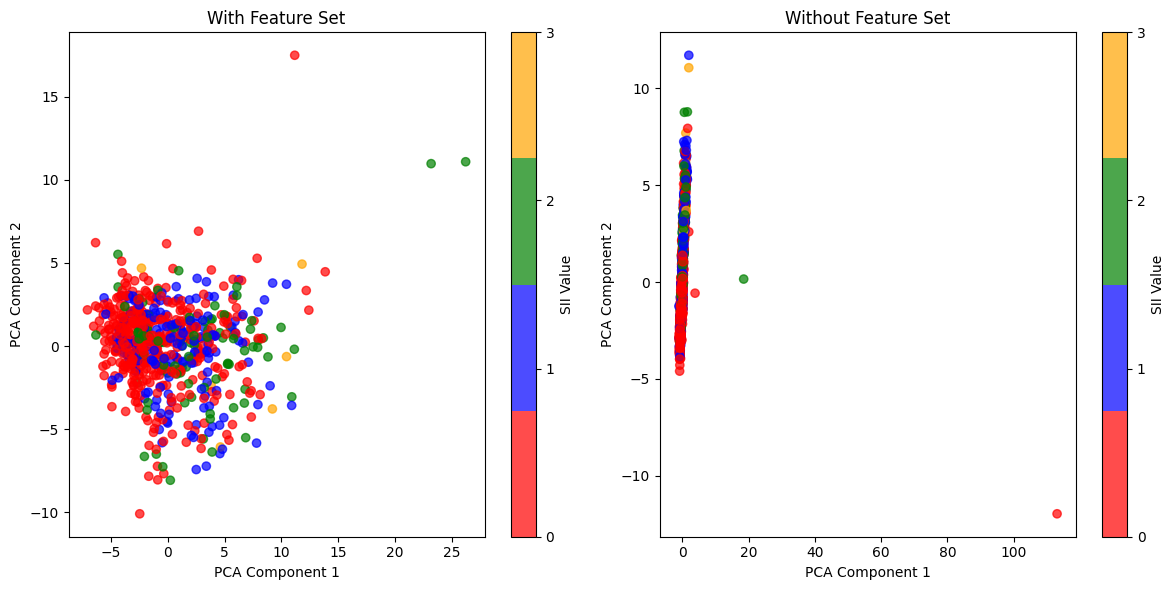

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from matplotlib.colors import ListedColormap

# # 使用 PCA 將資料降到 2D
# pca = PCA(n_components=2)
# X_train_with_2d = pca.fit_transform(X_train_with)
# X_train_without_2d = pca.fit_transform(X_train_without)

# # 定義離散顏色映射
# colors = ['red', 'blue', 'green', 'orange']  # 對應 SII 值 0, 1, 2, 3
# cmap = ListedColormap(colors)

# # 繪製散點圖
# plt.figure(figsize=(12, 6))

# # With feature set
# plt.subplot(1, 2, 1)
# sc1 = plt.scatter(X_train_with_2d[:, 0], X_train_with_2d[:, 1], c=y_train_with, cmap=cmap, alpha=0.7)
# plt.title('With Feature Set')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.colorbar(sc1, ticks=[0, 1, 2, 3], label='SII Value')  # 標註離散值

# # Without feature set
# plt.subplot(1, 2, 2)
# sc2 = plt.scatter(X_train_without_2d[:, 0], X_train_without_2d[:, 1], c=y_train_without, cmap=cmap, alpha=0.7)
# plt.title('Without Feature Set')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.colorbar(sc2, ticks=[0, 1, 2, 3], label='SII Value')  # 標註離散值

# plt.tight_layout()
# plt.show()

In [59]:
# 隨機森林的超參數網格
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# 使用 GridSearchCV 進行隨機森林的超參數搜尋
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, cv=5, scoring='f1_weighted')

# 訓練模型
grid_rf.fit(X_train_with, y_train_with)

# 輸出最佳參數和最佳 f1_weighted 分數
print("best parameter:", grid_rf.best_params_)
print("best f1_weighted:", grid_rf.best_score_)

# 取得最佳的隨機森林模型
best_model_with = grid_rf.best_estimator_

best parameter: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
best f1_weighted: 0.5770694674535325


In [ ]:
# # XGBoost 的超參數網格
# param_grid_xgb = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 10],
#     'scale_pos_weight': [1, 10]  # 針對不平衡標籤調整
# }

# # 使用 GridSearchCV 進行 XGBoost 的超參數搜尋
# grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=True), param_grid_xgb, cv=5, scoring='f1_weighted')

# # 訓練模型
# grid_xgb.fit(X_train_with, y_train_with)

# # 輸出最佳參數和最佳 f1_weighted 分數
# print("best parameter:", grid_xgb.best_params_)
# print("best f1_weighted:", grid_xgb.best_score_)

# # 取得最佳的 XGBoost 模型
# best_model_with = grid_xgb.best_estimator_

Test accuracy: 0.59
              precision    recall  f1-score   support

         0.0       0.68      0.81      0.74       173
         1.0       0.48      0.33      0.39        86
         2.0       0.22      0.22      0.22        37
         3.0       0.00      0.00      0.00         3

    accuracy                           0.59       299
   macro avg       0.35      0.34      0.34       299
weighted avg       0.56      0.59      0.57       299



/home/cho/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cho/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cho/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

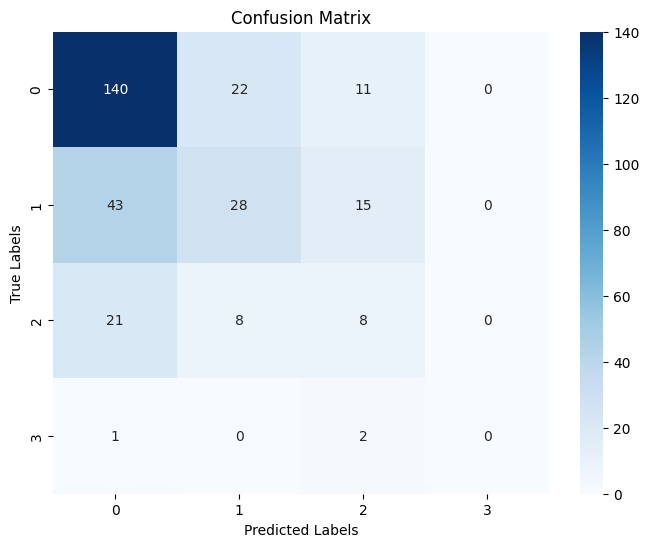

In [60]:
y_pred_with = best_model_with.predict(X_test_with)
print(f"Test accuracy: {accuracy_score(y_test_with, y_pred_with):.2f}")
print(classification_report(y_test_with, y_pred_with))
# 計算混淆矩陣
cm = confusion_matrix(y_test_with, y_pred_with)

# 使用seaborn畫出混淆矩陣圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [62]:
# 隨機森林的超參數網格
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# 使用 GridSearchCV 進行隨機森林的超參數搜尋
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, cv=5, scoring='f1_weighted')

# 訓練模型
grid_rf.fit(X_train_without, y_train_without)

# 輸出最佳參數和最佳 f1_weighted 分數
print("best parameter:", grid_rf.best_params_)
print("best f1_weighted:", grid_rf.best_score_)

# 取得最佳的隨機森林模型
best_model_without = grid_rf.best_estimator_

best parameter: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
best f1_weighted: 0.5862277618428895


Test accuracy: 0.53
              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71       312
         1.0       0.28      0.29      0.28       133
         2.0       0.27      0.29      0.28        70
         3.0       0.25      0.14      0.18         7

    accuracy                           0.53       522
   macro avg       0.38      0.35      0.36       522
weighted avg       0.54      0.53      0.53       522



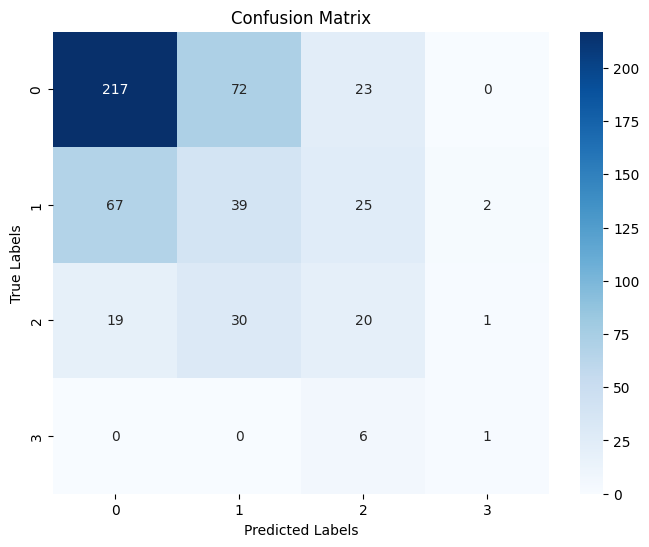

In [63]:
y_pred_without = best_model_without.predict(X_test_without)
print(f"Test accuracy: {accuracy_score(y_test_without, y_pred_without):.2f}")
print(classification_report(y_test_without, y_pred_without))
# 計算混淆矩陣
cm = confusion_matrix(y_test_without, y_pred_without)

# 使用seaborn畫出混淆矩陣圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [64]:
# Predict
test_df_with_parquet = test_df[test_df['with_parquet'] == True]
test_df_without_parquet = test_df[test_df['with_parquet'] == False]
parquet_features = ['actigraphy_season', 'weekend/weekday',
       'morning_enmo_mean', 'morning_enmo_std', 'morning_anglez_std',
       'afternoon_enmo_mean', 'afternoon_enmo_std', 'afternoon_anglez_std',
       'evening_enmo_mean', 'evening_enmo_std', 'evening_anglez_std',
       'night_enmo_mean', 'night_enmo_std', 'night_anglez_std',
       'sleep_disruption_count', 'light_exposure_during_sleep',
       'light_exposure_during_sleep_std',
       'light_exposure_during_sleep_disruption', 'sleep_position_changes',
       'good_sleep_cycle', 'wear_consistency', 'anglez -90 to -60',
       'anglez -60 to -30', 'anglez -30 to 0', 'anglez 0 to 30',
       'anglez 30 to 60', 'anglez 60 to 90', 'with_parquet']
test_df_without_parquet = test_df_without_parquet.drop(columns = parquet_features)
test_df_with_parquet = test_df_with_parquet.drop(columns = ['with_parquet'])

In [65]:
zone_data = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
test_df_without_parquet = test_df_without_parquet.drop(columns=zone_data)
test_df_with_parquet = test_df_with_parquet.drop(columns=zone_data)

In [68]:
# 不進行split，直接處理test數據
X = test_df_with_parquet.drop(columns=['id'])

# Standardization
scaler_with = StandardScaler()
X_scaled = scaler_with.fit_transform(X)

# Predict using the best model with the standardized data
pred_result = best_model_with.predict(X_scaled)

# Create a DataFrame with predictions and corresponding IDs
list_of_tuples = list(zip(pred_result, test_df_with_parquet['id'].values))
result_with_parquet = pd.DataFrame(list_of_tuples, columns=['sii', 'id'])

# Show the result
result_with_parquet

,sii,id
0,0.0,00115b9f
1,2.0,001f3379


In [69]:
# 不進行split，直接處理test數據
X = test_df_without_parquet.drop(columns=['id'])

# Standardization
scaler_without = StandardScaler()
X_scaled = scaler_without.fit_transform(X)

# Predict using the best model with the standardized data
pred_result = best_model_without.predict(X_scaled)

# Create a DataFrame with predictions and corresponding IDs
list_of_tuples = list(zip(pred_result, test_df_without_parquet['id'].values))
result_without_parquet = pd.DataFrame(list_of_tuples, columns=['sii', 'id'])

# Show the result
result_without_parquet


,sii,id
0,0.0,00008ff9
1,0.0,000fd460
2,2.0,00105258
3,1.0,0016bb22
4,0.0,0038ba98
5,0.0,0068a485
6,1.0,0069fbed
7,1.0,0083e397
8,2.0,0087dd65
9,1.0,00abe655


In [70]:
result = pd.concat([result_with_parquet, result_without_parquet], ignore_index=True)

In [71]:
result.to_csv('working/submission.csv', index=False)